In [72]:
import os
# Reqiured to suppress tensorflow annoying warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np

import spacy
import gensim
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


In [73]:
df = pd.read_csv("./data/output.csv")

### Data Cleaning

In [74]:
# "review_text" nan are to be deleted. Other can stay.
df = df.dropna(subset=["review_text"])

# Remove invalid entries
df = df.loc[df["entry_date"] != "entry_date"]

# Remove duplicate entries
df = df.drop_duplicates(["offer_ref", "entry_id", "review_text"]).drop_duplicates("review_text")


In [75]:
# fix data types
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["purchase_date"] = pd.to_datetime(df["purchase_date"])
df["entry_id"] = df["entry_id"].astype(int)
df["offer_ref"] = df["offer_ref"].astype(int)
df["score"] = df["score"].astype(float)

In [76]:
# Get Sentiment Cases based on score
df["sentiment"] = df["score"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

In [77]:
df["review_text"] = df["review_text"].replace("\n", " ", regex=True).replace("_+", " ", regex=True)

### Training Data Prep

In [78]:
# Get data to train the model on.
data_cleaned = df[["review_text", "sentiment"]].reset_index(drop=True).copy()

In [80]:
# Get Language Model
nlp = spacy.load("pl_core_news_lg")
spacy.lang.pl.stop_words.STOP_WORDS.remove("ok")
spacy.lang.pl.stop_words.STOP_WORDS.remove("nie")


In [81]:
gensim_model_file_path = "./gensim models/cbow.v300.m8.hs.mwe.w2v.gensim"
gensim_model = gensim.models.KeyedVectors.load(gensim_model_file_path)

In [82]:
data_cleaned["review_text"] = data_cleaned["review_text"].replace("ok", "OK", regex=True)

In [83]:
# Apply tokenizer (TAKES ROUGHLY 5 mins!!! on 40K reviews)
data_cleaned["review_text"] = data_cleaned["review_text"].transform(lambda x: nlp(x))

In [125]:
# result = tf.convert_to_tensor([[gensim_model.get_vector(token.lemma_) if (token.lemma_ in gensim_model.key_to_index) else np.zeros(300, dtype=np.float32) for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in data_cleaned['review_text'].iloc[2].sents][0])

In [126]:
# tf.concat([tf.reduce_mean(result, 0), tf.reduce_max(result, 0)], axis=0)

In [127]:
data_cleaned["vectored_form"] = data_cleaned["review_text"].transform(lambda x: [[token.vector for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: tf.convert_to_tensor([tf.concat([tf.reduce_mean(sentence, 0), tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))

# (
#     data_cleaned["review_text"].transform(lambda x: # x is a Doc object
#         tf.convert_to_tensor( # calculate mean of word vectors for each sentence. Tensors have different number of sentences.
#             [tf.reduce_mean(tf.constant([token.vector for token in sentence if (not token.is_stop) and (not token.is_punct)], dtype=tf.float64), 0) for sentence in x.sents]
#         )
#     )
# )

In [128]:
data_cleaned["vectored_form_gensim"] = data_cleaned["review_text"].transform(lambda x: [[gensim_model.get_vector(token.lemma_) if (token.lemma_ in gensim_model.key_to_index) else np.zeros(300, dtype=np.float32) for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: tf.convert_to_tensor([tf.concat([tf.reduce_mean(sentence, 0), tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))
# (
#     data_cleaned["review_text"].transform(lambda x: # x is a Doc object
#         tf.convert_to_tensor( # calculate mean of word vectors for each sentence. Tensors have different number of sentences.
#             [tf.reduce_mean(tf.constant([gensim_model.get_vector(token.lemma_) if token.lemma_ in gensim_model.key_to_index else np.zeros(300, dtype=np.float32) for token in x if (not token.is_stop) and (not token.is_punct)], dtype=tf.float64), 0) for sentence in x.sents]
#         )
#     )
# )

In [197]:
# Prepare target for categorical crossentropy
data_cleaned["target"] = data_cleaned["sentiment"].transform(lambda x: 1 if x == "Positive" else 0) #LabelEncoder().fit_transform(data_cleaned["sentiment"])

In [198]:
data_cleaned = data_cleaned[data_cleaned["review_text"].transform(lambda x: [[token.lemma_ if (token.lemma_ in gensim_model.key_to_index) else 0 for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: [sentence for sentence in x if len(sentence) > 0]).transform(lambda x: len(x)) != 0]

In [212]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size] 
        batch_x = tf.convert_to_tensor([tf.pad(x, [[0, 90 - x.shape[0]], [0, 0]]) for x in batch_x])
        batch_y = tf.convert_to_tensor(self.y[idx * self.batch_size:(idx + 1) * self.batch_size]) #tf.keras.utils.to_categorical(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], num_classes=3)
        return batch_x, batch_y

In [200]:
# Check how many zero tensors are present in data
# result = data_cleaned["vectored_form_gensim"].transform(lambda x: tf.reduce_all([tf.reduce_sum(y) == 0 for y in x]))

In [201]:
# result_1 = data_cleaned["vectored_form"].transform(lambda x: tf.reduce_all([tf.reduce_sum(y) == 0 for y in x]))

In [202]:
# data_cleaned["vectored_form"].to

In [203]:
# tf.pad(data_cleaned["vectored_form"].iloc[11002], [[0, 90 - data_cleaned["vectored_form"].iloc[11002].shape[0]], [0, 0]])

In [204]:
# data_cleaned["vectored_form"].transform(lambda x: tf.pad(x, [[0, 90 - x.shape[0]], [0, 0]]))

In [205]:
# tfds = tf.data.Dataset.from_tensor_slices((data_cleaned["vectored_form"], data_cleaned["target"]))

In [206]:
data_cleaned[["target", "sentiment"]]

,target,sentiment
0,0,Negative
1,0,Negative
2,0,Negative
3,0,Neutral
4,1,Positive
...,...,...
43121,1,Positive
43122,1,Positive
43123,1,Positive
43124,1,Positive


In [216]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data_cleaned.loc[data_cleaned["sentiment"].isin(["Positive", "Negative"]), "vectored_form_gensim"], data_cleaned.loc[data_cleaned["sentiment"].isin(["Positive", "Negative"]),"target"], test_size=0.2, random_state=42)
# Further split to get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

train_gen = DataGenerator(X_train, y_train, 1500)
val_gen = DataGenerator(X_val, y_val, 1500)
test_gen = DataGenerator(X_test, y_test, 1500)

In [217]:


# Clear session
keras.backend.clear_session()

# model initialization
model = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(128), input_shape=(90, 600)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model with loss suited for 3 categories: "Positive", "Negative", "Neutral"
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'],
)

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              746496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 763,473
Trainable params: 763,473
Non-trainable params: 0
_________________________________________________________________


In [218]:
# Fit Model and save history
history = model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
16/16 [==============================] - 10s 389ms/step - loss: 0.6501 - accuracy: 0.6132 - val_loss: 0.5999 - val_accuracy: 0.6867
Epoch 2/15
16/16 [==============================] - 6s 350ms/step - loss: 0.5526 - accuracy: 0.7601 - val_loss: 0.4832 - val_accuracy: 0.7848
Epoch 3/15
16/16 [==============================] - 6s 354ms/step - loss: 0.4301 - accuracy: 0.8206 - val_loss: 0.3873 - val_accuracy: 0.8315
Epoch 4/15
16/16 [==============================] - 6s 351ms/step - loss: 0.3690 - accuracy: 0.8429 - val_loss: 0.3616 - val_accuracy: 0.8506
Epoch 5/15
16/16 [==============================] - 6s 355ms/step - loss: 0.3403 - accuracy: 0.8583 - val_loss: 0.3383 - val_accuracy: 0.8656
Epoch 6/15
16/16 [==============================] - 6s 355ms/step - loss: 0.3228 - accuracy: 0.8682 - val_loss: 0.3336 - val_accuracy: 0.8698
Epoch 7/15
16/16 [==============================] - 6s 361ms/step - loss: 0.3131 - accuracy: 0.8722 - val_loss: 0.3188 - val_accuracy: 0.8686
Epoch

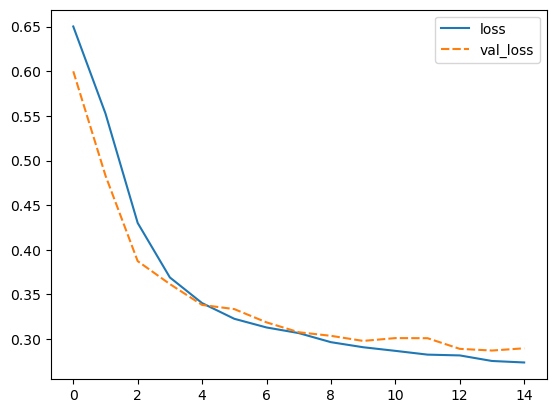

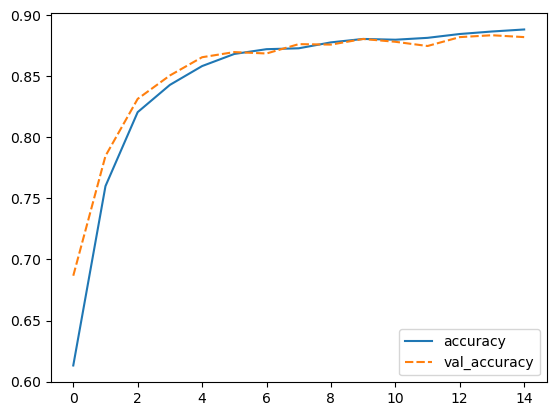

In [219]:
# plot loss history using seaborn

sns.lineplot(data=pd.DataFrame(history.history)[["loss", "val_loss"]])
plt.show()

# plot accuracy history using seaborn
sns.lineplot(data=pd.DataFrame(history.history)[["accuracy", "val_accuracy"]])
plt.show()

In [220]:
model.evaluate(test_gen)

5/5 [==============================] - 1s 263ms/step - loss: 0.2769 - accuracy: 0.8828


[0.27686941623687744, 0.8828125]